In [1]:
import pickle
import torch
import graph_tool as gt
import graph_tool.topology as top
import networkx as nx
from graph_tool import Graph
# from graph_tool.topology import remove_self_loops, remove_parallel_edges


def get_rings(edge_index, max_k=7):
    if isinstance(edge_index, torch.Tensor):
        edge_index = edge_index.numpy()

    edge_list = edge_index.T
    graph_gt = gt.Graph(directed=False)
    graph_gt.add_edge_list(edge_list)
    
    gt.generation.remove_self_loops(graph_gt) 
    gt.generation.remove_parallel_edges(graph_gt)

    
    # We represent rings with their original node ordering
    # so that we can easily read out the boundaries
    # The use of the `sorted_rings` set allows to discard
    # different isomorphisms which are however associated
    # to the same original ring – this happens due to the intrinsic
    # symmetries of cycles
    rings = set()
    sorted_rings = set()
    for k in range(3, max_k+1):
        pattern = nx.cycle_graph(k)
        pattern_edge_list = list(pattern.edges)
        pattern_gt = gt.Graph(directed=False)
        pattern_gt.add_edge_list(pattern_edge_list)
        sub_isos = top.subgraph_isomorphism(pattern_gt, graph_gt, induced=True, subgraph=True,
                                           generator=True)
        sub_iso_sets = map(lambda isomorphism: tuple(isomorphism.a), sub_isos)
        for iso in sub_iso_sets:
            if tuple(sorted(iso)) not in sorted_rings:
                rings.add(iso)
                sorted_rings.add(tuple(sorted(iso)))
    rings = list(rings)
    return rings

In [6]:
# load zinc250k dataset
with open('data/zinc250k_train_nx.pkl', 'rb') as f:
    zinc = pickle.load(f)

G = zinc[0]

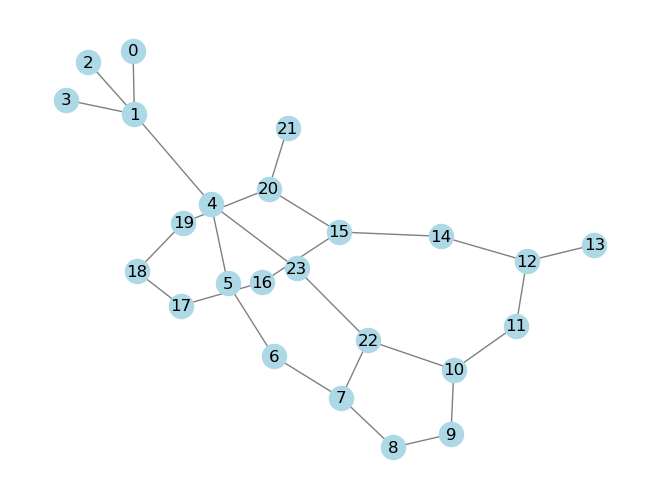

In [7]:
nx.draw(G, with_labels=True, node_color="lightblue", edge_color="gray")

In [2]:
def graph_to_edge_index(G):
    # Get edges
    edges = list(G.edges())
    # Convert to tensor format
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    return edge_index

In [9]:
G_edge_index = graph_to_edge_index(G)
print(G_edge_index)

tensor([[ 0,  1,  1,  1,  4,  4,  5,  6,  7,  7,  8,  9, 10, 10, 11, 12, 12, 14,
         15, 15, 16, 17, 18, 19, 20, 22],
        [ 1,  2,  3,  4,  5, 23,  6,  7,  8, 22,  9, 10, 11, 22, 12, 13, 14, 15,
         16, 20, 17, 18, 19, 20, 21, 23]])


In [10]:
get_rings(G_edge_index)

[(7, 8, 9, 10, 22), (15, 16, 17, 18, 19, 20), (4, 5, 6, 7, 22, 23)]

## Create 2-cells list for every molecule

In [12]:
# load zinc250k dataset
with open('data/qm9_test_nx.pkl', 'rb') as f:
    qm9 = pickle.load(f)

mol_test_rings = []

# iterate zinc
for graph in qm9:
    edge_index = graph_to_edge_index(graph)
    if edge_index.nelement() == 0:
        mol_test_rings.append([])
        continue
    rings = get_rings(edge_index)
    mol_test_rings.append(rings)

# store in pickle
with open('data/qm9_test_rings.pkl', 'wb') as f:
    pickle.dump(mol_test_rings, f)

with open('data/qm9_train_nx.pkl', 'rb') as f:
    qm9_train = pickle.load(f)

mol_train_rings = []
for graph in qm9_train:
    edge_index = graph_to_edge_index(graph)
    if edge_index.nelement() == 0:
        mol_train_rings.append([])
        continue
    rings = get_rings(edge_index)
    mol_train_rings.append(rings)

# store in pickle
with open('data/qm9_train_rings.pkl', 'wb') as f:
    pickle.dump(mol_train_rings, f)

In [8]:
# get rings for zinc250k

from tqdm import tqdm

zinc_train_rings = []
for graph in tqdm(zinc):
    edge_index = graph_to_edge_index(graph)
    rings = get_rings(edge_index)
    zinc_train_rings.append(rings)


100%|██████████| 224568/224568 [02:40<00:00, 1395.54it/s]


In [9]:
# count number of rings for each graph
zinc_train_rings_count = []
for rings in zinc_train_rings:
    zinc_train_rings_count.append(len(rings))

zinc_train_rings_len = []
for rings in zinc_train_rings:
    for ring in rings:
        zinc_train_rings_len.append(len(ring))

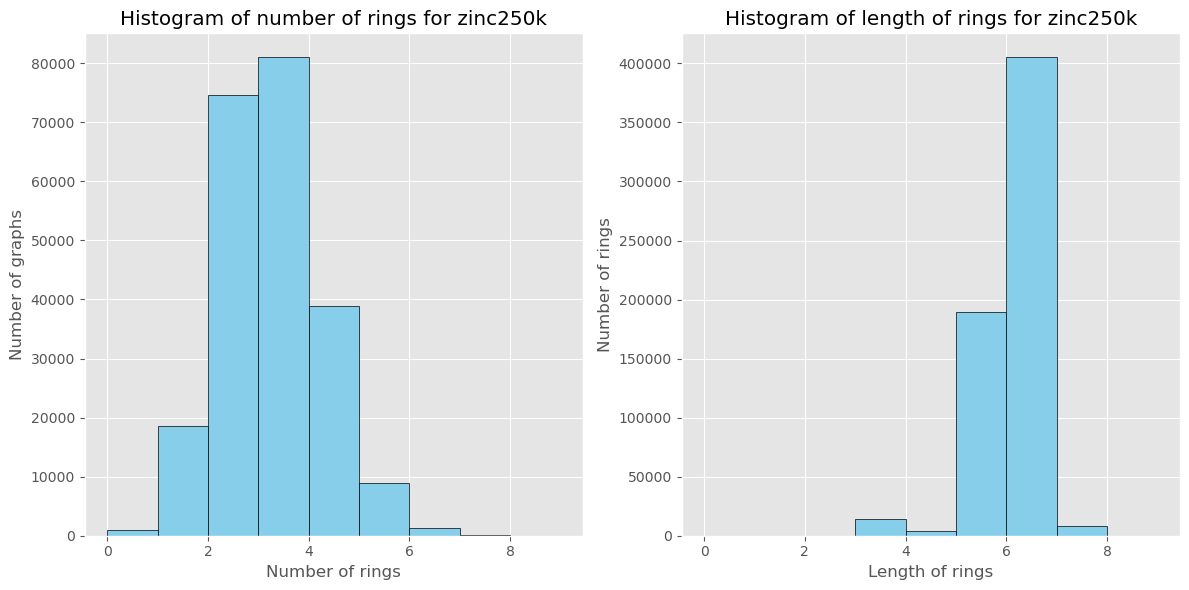

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Use a style for the plot
plt.style.use('ggplot')

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first histogram with a color and edge color
axs[0].hist(zinc_train_rings_count, bins=np.arange(0, 10, 1), color='skyblue', edgecolor='black')
axs[0].set_xlabel('Number of rings')
axs[0].set_ylabel('Number of graphs')
axs[0].set_title('Histogram of number of rings for zinc250k')

# Plot the second histogram with a color and edge color
axs[1].hist(zinc_train_rings_len, bins=np.arange(0, 10, 1), color='skyblue', edgecolor='black')
axs[1].set_xlabel('Length of rings')
axs[1].set_ylabel('Number of rings')
axs[1].set_title('Histogram of length of rings for zinc250k')

plt.tight_layout()
plt.show()

In [15]:
import pickle
from tqdm import tqdm
# load qm9 dataset
with open('data/qm9_train_nx.pkl', 'rb') as f:
    qm9 = pickle.load(f)

# get rings for qm9
qm9_rings = []
for graph in tqdm(qm9):
    edge_index = graph_to_edge_index(graph)
    # if no value in edge_index, skip
    if edge_index.nelement() == 0:
        continue
    rings = get_rings(edge_index)
    qm9_rings.append(rings)

# count number of rings for each graph
qm9_rings_count = []
for rings in qm9_rings:
    qm9_rings_count.append(len(rings))

qm9_rings_len = []
for rings in qm9_rings:
    for ring in rings:
        qm9_rings_len.append(len(ring))


100%|██████████| 120803/120803 [01:01<00:00, 1961.29it/s]


In [13]:
qm9_rings_count

[]

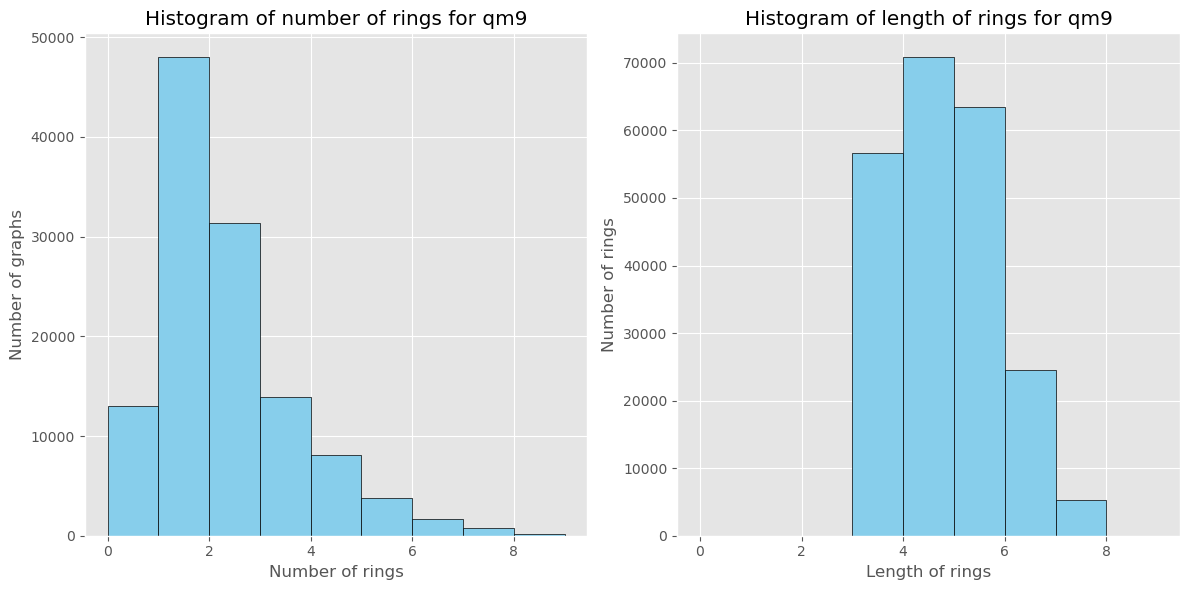

In [16]:
# plot histogram
import matplotlib.pyplot as plt
import numpy as np

# Use a style for the plot
plt.style.use('ggplot')

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first histogram with a color and edge color
axs[0].hist(qm9_rings_count, bins=np.arange(0, 10, 1), color='skyblue', edgecolor='black')
axs[0].set_xlabel('Number of rings')
axs[0].set_ylabel('Number of graphs')
axs[0].set_title('Histogram of number of rings for qm9')

# Plot the second histogram with a color and edge color
axs[1].hist(qm9_rings_len, bins=np.arange(0, 10, 1), color='skyblue', edgecolor='black')
axs[1].set_xlabel('Length of rings')
axs[1].set_ylabel('Number of rings')
axs[1].set_title('Histogram of length of rings for qm9')

plt.tight_layout()
plt.show()
